# Chapter 6 - Evolutionary Algorithms
### Deep Reinforcement Learning *in Action*

강화학습 진화 환경 : 신경망의 훈련을 위해 손실값을 최대 또는 최소화  
환경에 잘 적응하는 개체들만 남겨 자손 생성  
심층Q신경망, 정책기울기알고리즘 모두 확률적 경사 하강법 이용  
1) 최적점으로 수렴보장이 안됨, 초기 매개변수, 미니배치, 학습 속도 등 hyperparameter 조율이 중요  
2) 미분 가능한 모형만 사용 가능  

진화 강화학습(evolutionary reinforcement learning)에서는 주어진 환경에서 더 높은 보상을 얻는 에이전트의 형질(trait : 모형의 매개변수, 신경망 가중치 또는 모형의 전체적인 구조)을 다음 세대로 전달  
목적함수는 역전파 및 경사하강법과 동일(최대 보상을 위한 함수), 다만 매개변수 최적화 방식이 다름  

모든 에이전트는 같은 환경에서 실행, 무작위 초기화 후 적합도 개산하여 두 개체(부모)를 선택하여 자식 개체군 생성(교배, 변이 적용하여 원래 개체군과 같은 수 생성), 진화가 수렴할때까지 반복    
- 부모 선택은 적합도에 기반한 확률분포를 통하여 부모 추출, 또는 상위 N개 선택 (탐험 대 활용)  

##### Listing 6.1

In [22]:
import random
import numpy as np
from matplotlib import pyplot as plt

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! " #A
target = "Hello World!" #B

class Individual: #C
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness

from difflib import SequenceMatcher

def similar(a, b): #D
    return SequenceMatcher(None, a, b).ratio()

def spawn_population(length=26,size=100): #E
    pop = []
    for i in range(size):
        string = ''.join(random.choices(alphabet,k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop

# spawn_population으로 무작위 문자 생성 

#A This is the list of characters we sample from to produce random strings
#B This is the string we’re trying to evolve from a random population
#C We set up a simple class to store information about each member of the population
#D This method will compute a similarity metric between two strings, giving us a fitness score
#E This method will produce an initial random population of strings

##### Listing 6.2

In [23]:
def recombine(p1_, p2_): #A 두 개 문자 재조합하여 두개의 다른 문자열 생성
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []
    cross_pt = random.randint(0,len(p1))
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])
    c1 = Individual(''.join(child1))
    c2 = Individual(''.join(child2))
    return c1, c2

def mutate(x, mut_rate=0.01): # 0.01% 확률로 문자열 변이
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x_.extend(random.choices(alphabet,k=1))
        else:
            new_x_.append(char)
    new_x = Individual(''.join(new_x_))
    return new_x

#A This function recombines two parent strings into two new offspring
#B This function will mutate a string by randomly flipping characters

##### Listing 6.3  
각 개체군에 대한 적합도 점수 계산  
적합도 점수 기반으로 (매번) 부모 선택, 부모 recombine, 변이를 적용한 자식 생성해서 원본 개체군만큼 생성  

In [24]:
def evaluate_population(pop, target): #A 각 개체군 적합도 점수 계산 & 전체 평균 적합도
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, size=100, length=26, mut_rate=0.01): #B
    new_pop = []
    while len(new_pop) < size:
        # 각 개체군의 적합도 점수에 weight 주어서 부모 선택
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0],parents[1]) #부모 개체 재조합
        child1 = mutate(offspring_[0], mut_rate=mut_rate) #변이 통한 자식 개체 생성
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

#A This function assigns a fitness score to each individual in the population
#B This function generates a new generation by recombination and mutation

##### Listing 6.4

In [25]:
num_generations = 300
population_size = 1800
str_len = len(target)
mutation_rate = 0.00001 #A

pop_fit = []
pop = spawn_population(size=population_size, length=str_len) #B 무작위 문자 생성
done = False
for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target) 
    #각 개체군 적합도 점수 계산 & 전체 평균 적합도
    pop_fit.append(avg_fit) #C
    new_pop = next_generation(pop, \
        size=population_size, length=str_len, mut_rate=mutation_rate)
        # 각 개체군의 적합도 점수에 weight 주어서 부모 선택, 부모 재조합 => 변이 자식 생성   
    pop = new_pop
    for x in pop: 
        if x.string == target: 
            print("Target Found!")
            done = True
    if done:
        break
#A Set the mutation rate to 0.1%
#B Create the initial random population
#C Record population average fitness over training time

In [26]:
pop.sort(key=lambda x: x.fitness, reverse=True) #sort in place, highest fitness first
pop[0].string

'HeBllo Wrld!'

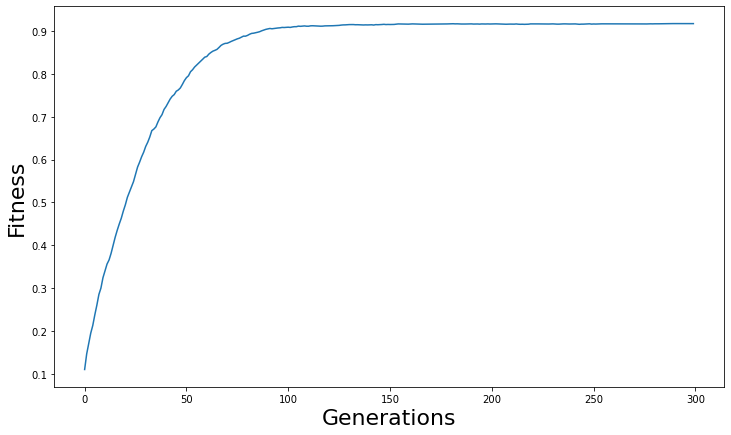

In [27]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Fitness",fontsize=22)
plt.plot(pop_fit)

변이 자체가 문자열 하나를 바꾸는 이산적인 행동, 이러한 이산값 개체들은 최적화도 어렵고, 매개변수들이 이산적이면 미분할 수 없어서 보통의 경사하강법과 역전파로는 최적화가 불가능

##### Listing 6.5
CartPole Example  
신경망의 매개변수 자체가 다음 세대에 전달되어야 하는 형질  

In [28]:
import torch

Total number of parameters: $4*25 + 25 + 10*25 + 10 + 2*10 + 2 = 407$

In [29]:
def model(x,unpacked_params):
    l1,b1,l2,b2,l3,b3 = unpacked_params #A 매개변수 벡터를 개별 층으로 분해
    y = torch.nn.functional.linear(x,l1,b1) #B bias가 포함된 것은 linear 계층
    y = torch.relu(y) #C relu 활성화 함수
    y = torch.nn.functional.linear(y,l2,b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l3,b3)
    y = torch.log_softmax(y,dim=0) #D 각 동작들에 대한 로그 확률분포 출력
    return y

#A Unpack the parameter vector into individual layer matrices
#B Simple linear layer with bias
#C Rectified linear unit activation function
#D The last layer will output log-probabilities over actions

##### Listing 6.6  
재조합과 변이처리를 편리하기 위해 각 층들의 매개변수 행렬을 1차원으로 펼쳐서 개체 표현 

In [30]:
# 4*25+25+10*25+10+2*10+2 = 407개 매개변수
# 4개 입력, 중간층(25, 10), 2개 출력
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]): #A
    unpacked_params = [] #B
    e = 0
    for i,l in enumerate(layers): #C
        s,e = e,e+np.prod(l)
        weights = params[s:e].view(l) #D 각 층의 개별 파라미터 벡터로 저장
        s,e = e,e+l[0]
        bias = params[s:e]
        unpacked_params.extend([weights,bias]) #E
        # 각 신경망 매겨밴수를 평평하게 하나의 벡터로 취급, 각 레이어별로 취급해서
        # 재조합하고 변이하려면 계산이 복잡해짐
    return unpacked_params

#A The `layers` parameter specifies the shape of each layer matrix
#B Store each individual layer tensor
#C Iterate through each layer
#D Unpack the indivudal layer into matrix form
#E Add the unpacked tensor to the list

##### Listing 6.7

In [31]:
def spawn_population(N=50,size=407): #A 무작위 개체군 생성
    pop = []
    for i in range(N):
        vec = torch.randn(size) / 2.0 #B
        fit = 0
        p = {'params':vec, 'fitness':fit} #C
        pop.append(p)
    return pop

#A `N` is the number of individuals in the population, `size` is the length of the parameter vectors
#B Create a randomly initialized parameter vector
#C Create a dictionary to store the parameter vector and its associated fitness score

In [32]:
(torch.randn(407)/2).std()

tensor(0.5239)

##### Listing 6.8

In [33]:
def recombine(x1,x2): #A x1, x2는 부모 에이전트 표현
    x1 = x1['params'] #B 매개변수 벡터만 사용
    x2 = x2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l) #C 무작위 분할
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt] #D 부모1과 부모2 분할&조합으로 자식 매개변수 벡터 생성
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = {'params':child1, 'fitness': 0.0} #E 새로운 자식 에이전트 생성 (fit:0)
    c2 = {'params':child2, 'fitness': 0.0}
    return c1, c2

#A x1 and x2 are agents which are dictionaries
#B Extract just the parameter vector
#C Randomly produce a split or crossover point
#D The first child is produced by taking the first segment of parent 1 and the second segment of parent 2
#E Create new children agents by packaging the new parameter vectors into dictionaries

In [34]:
evaluate_population

<function __main__.evaluate_population(pop, target)>

##### Listing 6.9

In [35]:
def mutate(x, rate=0.01): #A 0.01 변이 비율
    x_ = x['params']
    num_to_change = int(rate * x_.shape[0]) #B 변이 적용할 성분 개수
    idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,))
    x_[idx] = evaluate_populationevaluate_population #C 해당 인덱스 무작위 변형
    x['params'] = x_
    return x

#A `rate` is the mutation rate where 0.01 is a 1% mutation rate
#B Use the mutation rate to decide how many elements in the parameter vector to mutate
#C Randomly reset the selected elements in the parameter vector

##### Listing 6.10

In [36]:
import gym
env = gym.make("CartPole-v0")

In [37]:
def test_model(agent):
    done = False
    state = torch.from_numpy(env.reset()).float()
    score = 0
    while not done: #A 에피소드 끝나기 전까지 시행
        params = unpack_params(agent['params']) 
        probs = model(state,params) #B 에이전트 매개변수로 신경망 모형 정의
        action = torch.distributions.Categorical(probs=probs).sample() #C 범주형 샘플링 
        state_, reward, done, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1 #D 막대가 쓰러지지 않고 진행된 단계가 점수
    return score

#A While game is not lost
#B Get the action probabilities from the model using the agent's parameter vector
#C Probabilistically select an action by sampling from a categorical distribution
#D Keep track of the number of time steps the game is not lost as the score

##### Listing 6.11

In [38]:
def evaluate_population(pop): #개체군의 모든 에이전트 평가
    tot_fit = 0 #A 적합도 총합
    lp = len(pop)
    for agent in pop: #B
        score = test_model(agent) #C
        agent['fitness'] = score #D
        tot_fit += score
    avg_fit = tot_fit / lp
    return pop, avg_fit

#A Total fitness for this population; used to later calculate the average fitness of the population
#B Iterate through each agent in the population
#C Run the agent in the environment to assess its fitness
#D Store the fitness value

##### Listing 6.12

In [39]:
# 토너먼트식 선택 
def next_generation(pop,mut_rate=0.001,tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop): #A
        rids = np.random.randint(low=0,high=lp,size=(int(tournament_size*lp))) #B 일정 비율 부분집합 보존
        batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids]) #C B의 부분집합 생성
        scores = batch[batch[:, 1].argsort()] #D 부분 집합 개체 적합도 순으로 정렬
        i0, i1 = int(scores[-1][0]),int(scores[-2][0]) #E 최상의 두 개체를 부모로 선택
        parent0,parent1 = pop[i0],pop[i1]
        offspring_ = recombine(parent0,parent1) #F 재조합으로 자식 생산
        child1 = mutate(offspring_[0], rate=mut_rate) #G 변이 적용하여 다음 세대 추가
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

#A While the new population is not full
#B Select a percentage of the full population as a subset
#C Subset the population to get a batch of agents and match each one with their index value in the original population
#D Sort this batch in increasing order of score
#E The last agents in the sorted batch are the agents with the highest scores; select the top 2 as parents
#F Recombine the parents to get offspring
#G Mutate the children before putting them into the next generation

##### Listing 6.13

In [40]:
num_generations = 20 #A
population_size = 500 #B
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size,size=407) #C 개체군 초기화
for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop) #D 적합도 평가 
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate,tournament_size=0.2) #E
    # 다음 세대 생산 
#A The number of generations to evolve
#B The number of individuals in each generation
#C Initialize a population
#D Evaluate the fitness of each agent in the population
#E Populate the next generation

NameError: name 'evaluate_populationevaluate_population' is not defined

In [ ]:
def running_mean(x,n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0]-n)
    for i in range(x.shape[0]-n):
        y[i] = (conv @ x[i:i+n]) / n
    return y

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))

In [ ]:
test_model(pop[0])

In [ ]:
plt.figure(figsize=(15,7))
plt.axis('off')
plt.xlabel("Compute resources",fontsize=22)
plt.ylabel("Performance",fontsize=22)
x = np.linspace(0,100,1000)
y = np.log(x)
plt.plot(x,y)

# 진화 알고리즘 장단점  
1) 탐험이 강하게 작용 : 심층Q신경망(엡실론 탐욕 전략으로 가끔 무작위)과 정책기울기 방법(확률적으로 동작 추출함으로써 탐험 보강)은 경험 기반으로 보상이 더 큰쪽으로 훈련, 유전 알고리즘은 무작위 생성된 에이전트 진화-> 다른 정책을 가진 에이전트들이 만들어지므로 탐험이 강하게 작용(변이 비율 조절)  
2) 표집 비용이 아주 큼 : 가중치를 업데이트해나가는 경사하강법과 달리 진화 알고리즘은 다수 에이전트를 실제환경에서 변이/재조합 진행하므로 개체군 갱신에 많은 데이터 필요 -> 많은 실행 및 관리를 위해 시뮬레이터 고안    
3) 역전파 계산이 없기 때문에 처리 속도가 빠르고 병렬화에 의한 규모가변성이 아주 좋음  

- 유전 알고리즘 (genetic algorithm) : 세대를 거듭하며 재조합과 변이에 의해 개체들의 유전자가 점점 갱신  
- 진화 전략 알고리즘 (evolutionary strategy, ES) :  
- 1) 약간의 잡음을 섞어서 하나의 부모 객체를 복제해서 조금씩 다른 자손 생산  
- 2) 각 자손들의 환경에 대한 적합도 점수 배정  
- 3) 자손들의 적합도 가중합으로 하나의 부모 개체 생산   
- 장점) 변이만 일어나고 부모 조각을 재조합하는 과정 없으므로 구현이 쉽고 속도 빠르다, 병렬화도 쉽게 진행 가능  



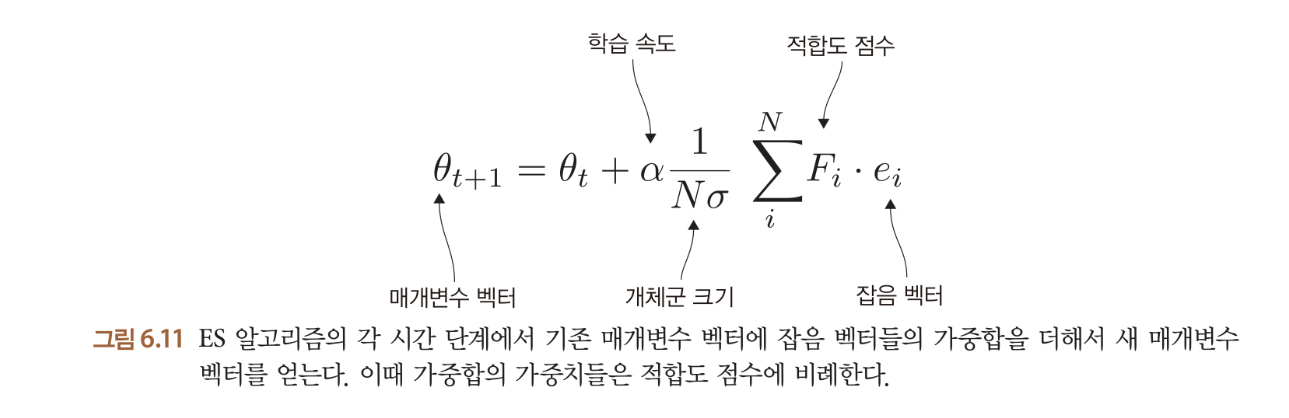

확장 효율성 = 자원 추가 후 성능 증가비율 / 자원 추가 비율  
병렬 처리를 한다해도 모든 에이전트의 종료를 기다리고 결과 취합해야함  
하나의 마스터 노드가 다른 프로세서 관리하는 방식 -> 노드간 네트워크 통신 발생  

OpenAI 연구자들이 노드간 통신시 벡터 전체가 아닌 수치 하나만 보내서 master node가 필요없는 분산 컴퓨팅 전략 개발  
- 모든 worker는 동일한 부모 매개변수 벡터로 초기화 & 각자의 잡음 벡터 추가  
- 모든 worker가 random seed 값을 공유, 서로의 적합도 점수만 전송  
- 각 worker는 각자의 다른 매개변수를 가지게 되고, 상대방의 적합도 점수만 받고 공유된 random seed 값으로 상대방의 매개변수 벡터 복원  
이러한 노드 간 통신 방식으로 자원을 늘린만큼 정비례하게 성능 증가됨 -> 선형 규모 확장  

기울기 기반 접근 방식의 규모 확장 : 각 worker node에서 agent 실행하고 해당 기울기를 중앙 서버로 보내서 처리 -> 네트워크 통신량이 많고 중앙 서버 처리 부담이 큼, 일정 자원 추가 이상으로는 더이상 성능이 나아지지 않음  

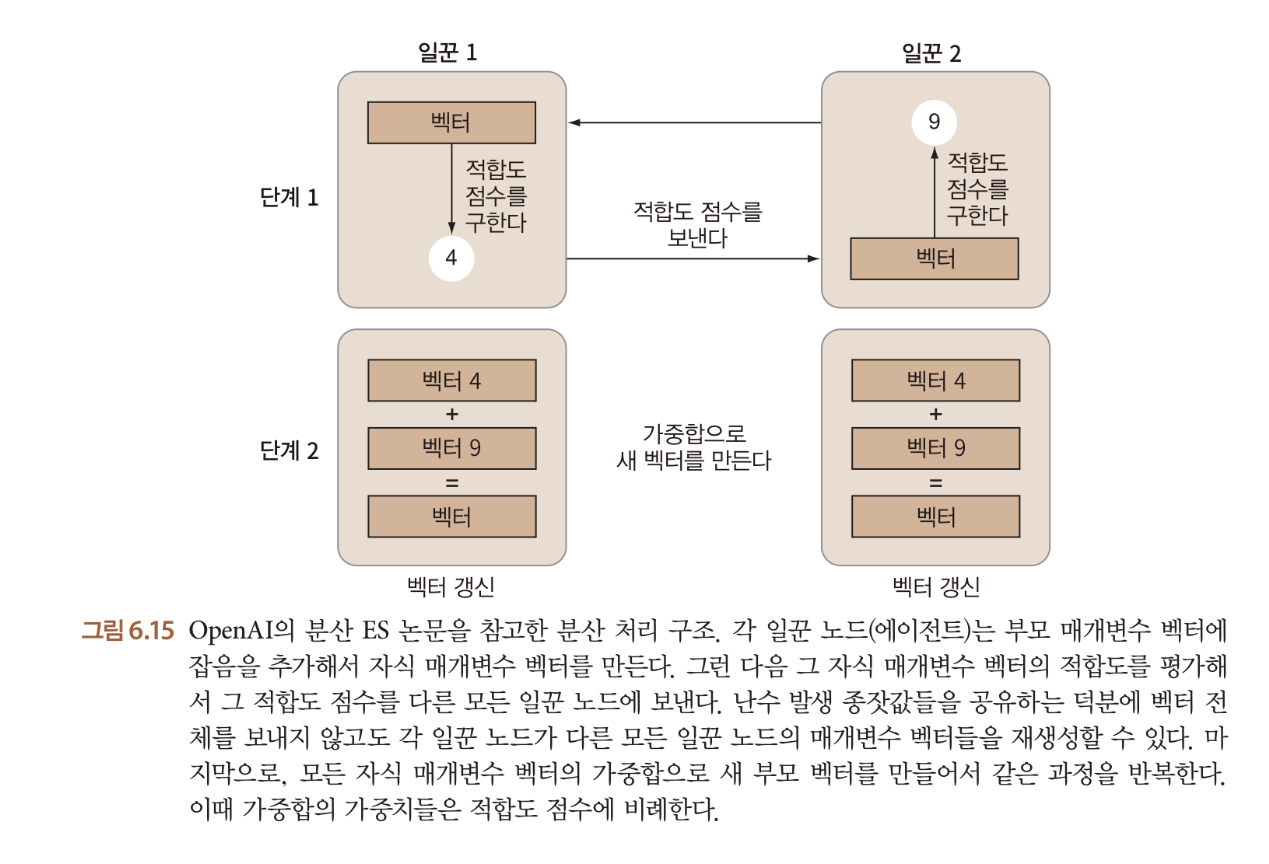